In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
spacy_ru = spacy.load('ru_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_ru(text):
    """
    Tokenizes Russian text from a string into a list of strings
    """
    return [tok.text for tok in spacy_ru.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [4]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_ru, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [5]:
path_to_data = "../data.txt"

In [6]:
dataset = TabularDataset(
    path=path_to_data,
    format='tsv',
    fields=[('src', SRC), ('trg', TRG)]
)

In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [8]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [9]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

In [10]:
from my_network import Attention, Encoder, Decoder, Seq2Seq

In [11]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [30]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6802, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(9318, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=9318, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [17]:
from my_utils import count_parameters

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 27,267,174 trainable parameters


In [18]:
optimizer = optim.Adam(model.parameters())

In [12]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [13]:
from my_utils import train_gru, evaluate_gru, epoch_time

In [23]:
for x in train_iterator:
    break

In [24]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_graph(model, input_to_model=(*x.src, x.trg, torch.LongTensor(1)))
writer.close()

<ipython-input-13-ea8c6dc9004d>:64: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert (output == hidden).all()
<ipython-input-14-73ff751608d6>:58: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  input = trg[t] if teacher_force else top1


In [25]:
%load_ext tensorboard
%tensorboard --logdir runs

In [26]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train_gru(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate_gru(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "./models/lstm_lstm_with_attention.pt")
    
    writer.add_scalar('mean train loss per epoch', train_loss, global_step=epoch)
    writer.add_scalar('mean val loss per epoch', valid_loss, global_step=epoch)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 15s
	Train Loss: 5.110 | Train PPL: 165.715
	 Val. Loss: 4.980 |  Val. PPL: 145.452
Epoch: 02 | Time: 1m 14s
	Train Loss: 3.661 | Train PPL:  38.887
	 Val. Loss: 4.611 |  Val. PPL: 100.572
Epoch: 03 | Time: 1m 16s
	Train Loss: 3.089 | Train PPL:  21.963
	 Val. Loss: 4.515 |  Val. PPL:  91.344
Epoch: 04 | Time: 1m 15s
	Train Loss: 2.713 | Train PPL:  15.075
	 Val. Loss: 4.372 |  Val. PPL:  79.204
Epoch: 05 | Time: 1m 16s
	Train Loss: 2.409 | Train PPL:  11.127
	 Val. Loss: 4.221 |  Val. PPL:  68.073
Epoch: 06 | Time: 1m 16s
	Train Loss: 2.192 | Train PPL:   8.954
	 Val. Loss: 4.314 |  Val. PPL:  74.725
Epoch: 07 | Time: 1m 15s
	Train Loss: 1.979 | Train PPL:   7.239
	 Val. Loss: 4.311 |  Val. PPL:  74.483
Epoch: 08 | Time: 1m 14s
	Train Loss: 1.845 | Train PPL:   6.328
	 Val. Loss: 4.348 |  Val. PPL:  77.313
Epoch: 09 | Time: 1m 16s
	Train Loss: 1.688 | Train PPL:   5.409
	 Val. Loss: 4.467 |  Val. PPL:  87.112
Epoch: 10 | Time: 1m 15s
	Train Loss: 1.587 | Train PPL

Можно заметить, что модель переобучилась, потому что val_loss начал расти с 6 эпохи.

In [27]:
torch.cuda.empty_cache()

In [14]:
model.load_state_dict(torch.load("./models/lstm_lstm_with_attention.pt"))

<All keys matched successfully>

In [16]:
num_batches = len(test_data.examples) // test_iterator.batch_size
start_time = time.time()
test_loss = evaluate_gru(model, test_iterator, criterion)
elapsed_time = (time.time() - start_time) 
time_per_32_batch = elapsed_time / num_batches / 4

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} | Inference time if batch_size=32: {time_per_32_batch:.3f} sec')

| Test Loss: 4.231 | Test PPL:  68.774 | Inference time if batch_size=32: 0.022 sec


In [30]:
from my_utils import gru_display_attention, gru_translate_sentence

In [52]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = some of the suites feature a spa bath .
trg = в некоторых люксах установлена гидромассажная ванна .


In [53]:
translation, attention = gru_translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {" ".join(translation)}')

predicted trg = в некоторых люксах установлена гидромассажная ванна . <eos>


<ipython-input-30-98e7d903867b>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-30-98e7d903867b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


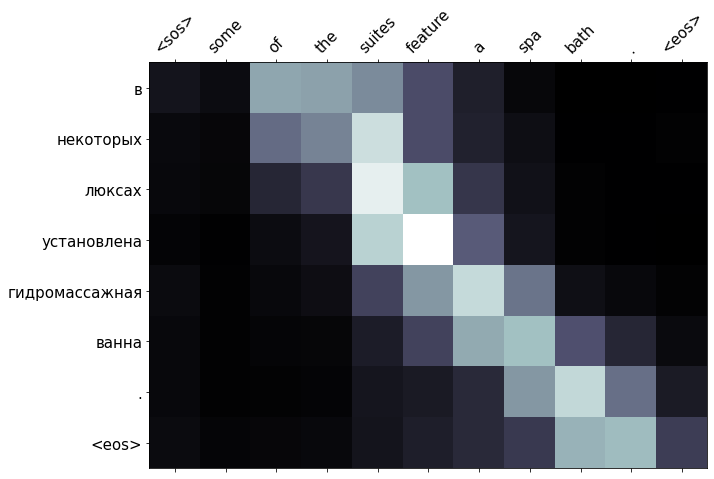

In [54]:
gru_display_attention(src, translation, attention)

In [61]:
example_idx = 7

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = breakfast is available as well .
trg = для гостей сервируется завтрак .


predicted trg = завтрак сервируется завтрак . <eos>


<ipython-input-30-98e7d903867b>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-30-98e7d903867b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


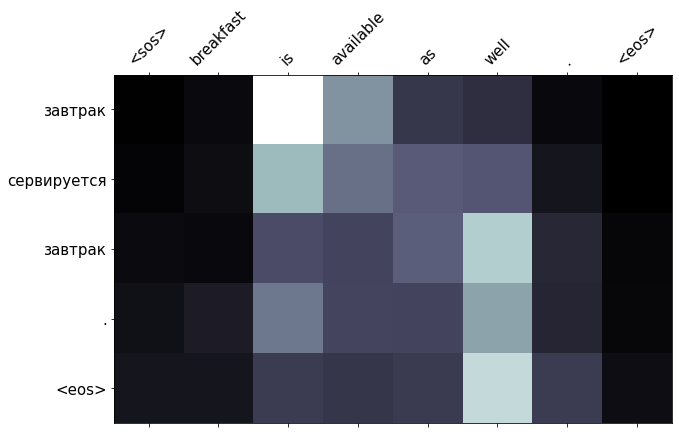

In [62]:
translation, attention = gru_translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {" ".join(translation)}')

gru_display_attention(src, translation, attention)

In [46]:
example_idx = 21

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = it offers a sun terrace with an outdoor pool and a poolside bar .
trg = к услугам гостей солнечная терраса с открытым бассейном и баром у бассейна .


predicted trg = к услугам гостей солнечная терраса с открытым бассейном и бар . <eos>


<ipython-input-30-98e7d903867b>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-30-98e7d903867b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


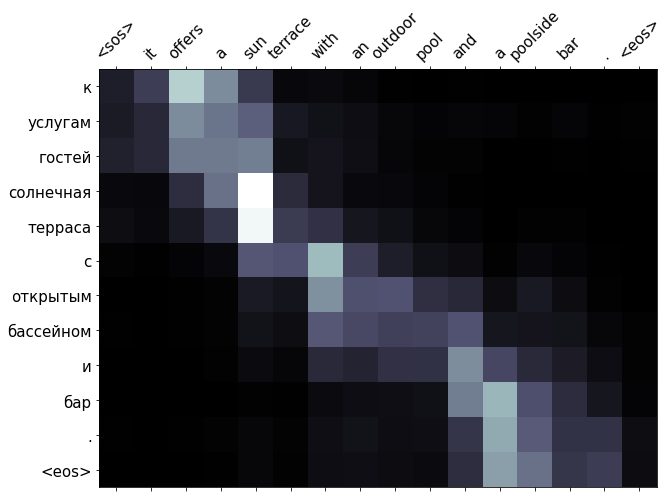

In [47]:
translation, attention = gru_translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {" ".join(translation)}')

gru_display_attention(src, translation, attention)

In [3]:
from my_utils import calculate_bleu

In [43]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 21.71
